In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import corner
import scipy.stats as stats

In [2]:
prior_file = '../pbjam/data/prior_data.csv'

prior = pd.read_csv(prior_file)
prior = prior.drop(columns=['ID', 'eps_g', 'p_L0', 'p_D0', 'alpha_g', 'u1', 'u2', 'DPi1'])
prior = prior.dropna()
''' If you want to reduce the volume of the prior - here is the place to do it!'''
prior = prior[prior.numax > np.log10(800.0)]
print(len(prior))
prior.head()

129


,numax,dnu,teff,bp_rp,eps_p,d02,alpha_p,env_height,env_width,mode_width,H1_nu,H1_exp,H_power,H2_nu,H2_exp,d01
13545,3.162672,1.881135,3.826075,0.575040,0.844761,0.767839,-2.695059,0.401082,2.307066,0.174625,3.218119,3.652768,3.137152,2.681778,3.308408,1.530153
13546,3.172406,1.881879,3.780245,0.766897,1.278135,0.710442,-2.548862,0.402757,2.292339,0.148777,3.152802,2.922546,3.204265,2.597299,3.325006,1.541007
13547,3.063642,1.787840,3.799065,0.660747,1.148833,0.711050,-2.908139,0.581869,2.207637,0.066642,3.082645,3.171502,3.103027,2.554328,3.048859,1.441060
13548,3.203482,1.897359,3.799616,0.663745,1.104225,0.808687,-2.929498,0.270082,2.296077,0.113081,3.201763,2.840464,3.138864,2.659919,3.352889,1.570424
13549,3.146686,1.862615,3.806655,0.715504,0.993497,0.709866,-3.053164,0.143703,2.211589,0.086142,3.113774,3.009173,3.158740,2.534407,3.465917,1.528664


In [5]:
class params():
    def __init__(self, prior: pd.core.frame.DataFrame, pca_components=5):
        self.prior_cloud = prior
        self.ndim = pca_components
        self.obs = {}
        
    def set_obs(self, name: str, vals: np.array):
        ''' Set an observable in the observable dictionary
        
        name: str
            name of the observable that matches an observable in the prior
            
        vals: arraylike
            [mean, uncertainty]
        '''
        self.obs[name] = vals
        
    def run_pca(self):
        ''' Run PCA on the prior to get a continuous latent representation '''
        X = self.prior_cloud.values
        from sklearn.decomposition import PCA
        self.pca = PCA(n_components=self.ndim)
        latent = self.pca.fit_transform(X)
        print(f'PCA Explained variance total = {np.sum(self.pca.explained_variance_ratio_)}')
        self.latent_mean = np.mean(latent, axis=0)
        self.latent_std = np.std(latent, axis=0)
        
    def prior_transform(self, u):
        ''' Transform from unit cube to latent space '''
        x = np.copy(u)
        for i in range(self.ndim):
            x[i] = stats.norm.ppf(x[i], loc=self.latent_mean[i], scale=self.latent_std[i])
        return x
    
    def log_likelihood(self, latent):
        p = self.pca.inverse_transform(latent)
        ll = 0.0
        for name, val in self.obs.items():
            idx = list(self.prior_cloud.columns.values).index(name)
            ll += stats.norm.logpdf(p[idx], loc=val[0], scale=val[1])
        return ll
    
    def sample(self):
        import dynesty
        sampler = dynesty.NestedSampler(self.log_likelihood, self.prior_transform, self.ndim,
                                bound='single', nlive=500)
        sampler.run_nested()
        samples_equal = sampler.results.samples_equal()
        return  self.pca.inverse_transform(samples_equal)
        
    def __call__(self):
        print(self.prior_cloud.head())


In [21]:
class spec2seismo():
    def __init__(self):
        self.numax_solar = 3050.0
        self.dnu_solar = 135.0 
        self.teff_solar = 5777.0
    
    def numax(self, M, R, Teff):
        return M * R**-2 * (Teff/self.teff_solar)**-0.5 * self.numax_solar
    
    def dnu(self, M, R, Teff):
        return M**0.5 / R**(3/2) * self.dnu_solar
    
    def monte_carlo(self, M, R, T, M_unc, R_unc, T_unc, npts = 1000):
        M_ = np.random.randn(npts) * M_unc + M
        R_ = np.random.randn(npts) * R_unc + R
        T_ = np.random.randn(npts) * T_unc + T
        numax_ = self.numax(M_, R_, T_)
        dnu_ = self.dnu(M_, R_, T_)
        '''print(f'Numax = {np.mean(numax_)} /pm {np.std(numax_)}')
        print(f'Dnu = {np.mean(dnu_)} /pm {np.std(dnu_)}')'''
        
        print(f'Log10 Numax = {np.mean(np.log10(numax_))} /pm {np.std(np.log10(numax_))}')
        print(f'Log 10 Dnu = {np.mean(np.log10(dnu_))} /pm {np.std(np.log10(dnu_))}')
        print(f'Log10 Teff = {np.mean(np.log10(T_))} \pm {np.std(np.log10(T_))}')
    
    def __call__(self, M, R, Teff):
        return self.numax(M, R, Teff), self.dnu(M, R, Teff)
        
conv = spec2seismo()
conv(1, 1, 5777.0)
conv.monte_carlo(1, 1, 5777.0, 0.05, 0.02, 70.0)

Log10 Numax = 3.483924507269782 /pm 0.028230616842896863
Log 10 Dnu = 2.1300076316288443 /pm 0.01709282664741337
Log10 Teff = 3.761457207036872 \pm 0.005434452944099727


In [19]:
p = params(prior)
p.set_obs('numax', [3.483, 0.028])
p.set_obs('dnu', [2.130, 0.017])
p.set_obs('teff', [3.762, 0.005])
p.set_obs('bp_rp', [0.82, 0.01]) # Solar value from Casagrande 2018 
p.run_pca()

u = np.random.rand(5)
latent = p.prior_transform(u)
p.log_likelihood(latent)
samples = p.sample()

PCA Explained variance total = 0.9578209699547271


3487it [01:32, 37.52it/s, +500 | bound: 105 | nc: 1 | ncall: 96814 | eff(%):  4.140 | loglstar:   -inf < 13.855 <    inf | logz:  7.712 +/-  0.101 | dlogz:  0.001 >  0.509]


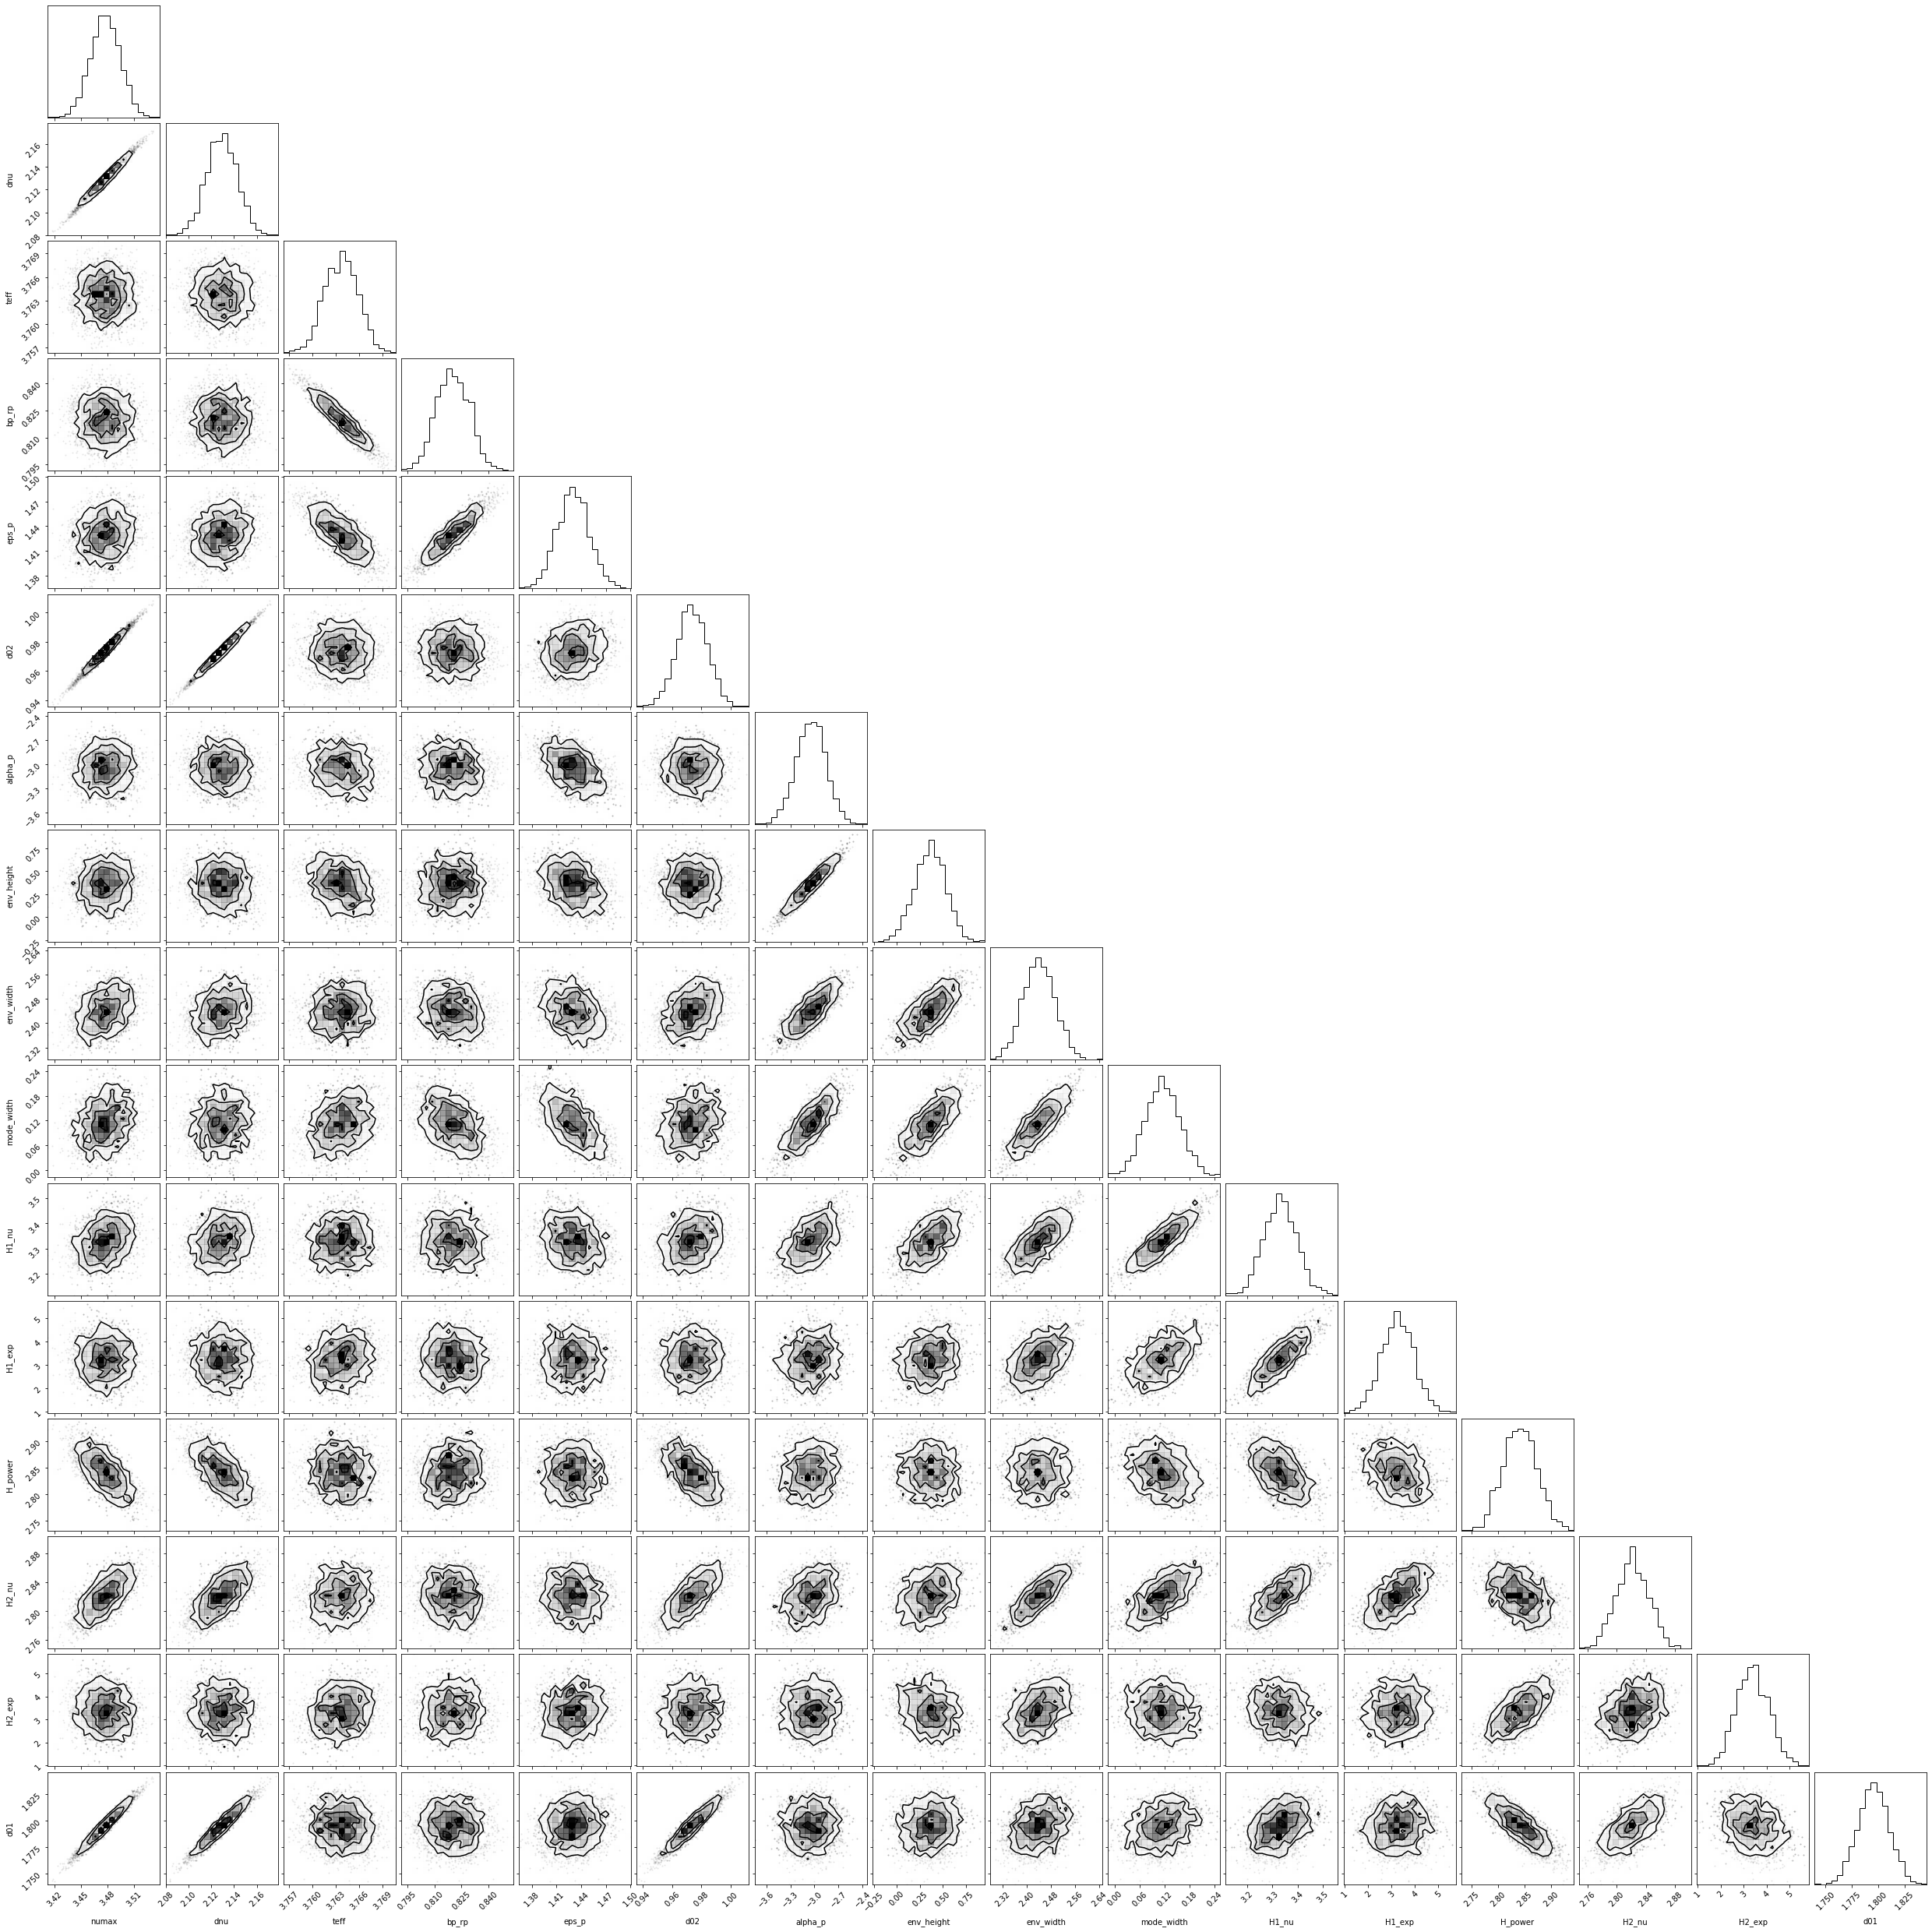

In [20]:
corner.corner(samples, labels=p.prior_cloud.columns);

In [22]:
samples_df = pd.DataFrame(data=samples, columns=p.prior_cloud.columns)
samples_df.to_csv('examples_samples.csv', index=False)